# **Reporte Hito 2**

**Fecha:** Octubre 2022

**Autores:** Armin Rodríguez, Rodrigo Valenzuela, Nicolás Hidalgo, Pablo Nahuelpán

## Índice de contenidos
* [Introducción](#item1)
* [Cargando conjunto de datos y librerías](#item2)
* [Limpieza de dataset](#item3)
* [Exploración de Datos](#item4)
* [Preguntas y Problemas](#item5)
* [Propuesta Experimental](#item6)
* [Experimento preliminar](#item7)
* [Trabajo realizado](#item8)
* [Referencias](#item9)
* [Anexo](#item10)

<a name="item1"></a>
## Introducción

Hearthstone es un juego de cartas coleccionables creado por la empresa Blizzard [1]. Este juego ha visto hasta 6.5 millones de jugadores concurrentes y debido a su popularidad sitios como Hearthpwn.com [2] fueron desarrollados para permitirle a los jugadores una herramienta para crear y compartir mazos de prueba.

Heartpwn nos ha encargado con la búsqueda de factores que permitan clasificar mazos de cartas en categorías que no estaban definidas dentro de las diferentes plataformas que serán futuramente absorbidas por el sitio. Esto con el objetivo de clasificar los datos no cubiertos por ellas como los nuevos formatos de juegos implementados que son estándar y salvaje.

En este reporte se analizarán resultados relacionados a la clasificación de mazos a través de las categorías provistas por parte de Heartpwn para asistir en la introducción de datos de mazos externos a su plataforma. El objetivo final siendo el desarrollo de uno o más modelos experimentales que puedan asistir a esta tarea.

En el conjunto de datos se encuentran registrados distintos mazos subidos a la plataforma de Heartpwn desde el año 2013 hasta 2017 y fueron proporcionados por el sitio Kaggle [3].




<a name="item2"></a>
## Cargando conjunto de datos y librerias
Se realiza la carga del conjunto de datos [3] para trabajar.

In [6]:
 #Se ejecuta para poder cargar código de R que teníamos anteriormente.
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import collections
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import OrderedDict
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
decks <- read.csv2("https://raw.githubusercontent.com/ArminRodriguez1/ig_Datos/main/data.csv")
head(decks)

  craft_cost       date deck_archetype deck_class deck_format deck_id  deck_set
1       9740 19/02/2016        Unknown     Priest           W  433004 Explorers
2       9840 19/02/2016        Unknown    Warrior           W  433003 Explorers
3       2600 19/02/2016        Unknown       Mage           W  433002 Explorers
4      15600 19/02/2016        Unknown    Warrior           W  433001 Explorers
5       7700 19/02/2016        Unknown    Paladin           W  432997 Explorers
6       5740 19/02/2016        Unknown    Warrior           W  432995 Explorers
     deck_type rating                           title         user card_0
1 Tavern Brawl      1                     Reno Priest    FunKaliTy      9
2  Ranked Deck      1                  RoosterWarrior RooosterRooo     75
3  Theorycraft      1                        Annoying      Messalm    195
4         None      0     Standart pay to win warrior    KingSneak     75
5  Ranked Deck      1                         Palamix  kowdog_1507    

In [9]:
decks = %R decks

<a name="item3"></a>
##Limpieza de dataset

Se realiza una limpieza de las variables no relevantes, con grandes cantidades de variables vacías, incorrectas o faltantes. Lo primero que se realizó fue evaluar las variables que no tenían relevancia en el contexto planteado, dejando solo las variables deseadas, posteriormente se limpiaron dichas variables dejando únicamente las que ofrecían información relevante para el contexto.

Varaibles no relevantes : 
* craft_cost
* deck_set
* title
* user
* rating
* deck_id

Se tiene en la mira la variable con datos faltantes, erróneos o nulos

* deck_archetype

Tenemos que verificar si esta variable puede ser relevante para la propuesta experimental, en caso de ser afirmativo, entonces se tiene pensado limpiar los datos dejando solo los valores que son conocidos y eliminar los datos desconocidos de dicha variable.

El dataset actualmente contiene datos desde el año 2013, esto no es algo favorable para lo que necesitamos, ya que en ese momento el juego estaba en fase "beta", por lo tanto las cartas y decks no son relevantes para el análisis final. Por lo que se eliminara los datos que sean anterior al 11 de marzo del 2014. Siendo esta la fecha de salida del juego para todo público. 

In [10]:
filter_deck = decks.copy()
filter_deck.drop(['craft_cost','deck_set', 'title', 'user', 'rating', 'deck_id'], axis = 'columns', inplace=True)
filter_deck.head()
column_list = filter_deck.columns
total_rows=len(filter_deck.axes[0])
print("Cantidad de filas presentes luego del filtrado: "+str(total_rows))
print('Cantidad de columnas presentes luego del filtrado:', len(column_list))

Cantidad de filas presentes luego del filtrado: 346232
Cantidad de columnas presentes luego del filtrado: 35


In [11]:
filter_deck['date'] = pd.to_datetime(decks['date'])
print ('First deck :', min(filter_deck['date']))
print ('Last deck :', max(filter_deck['date']))

First deck : 2013-01-06 00:00:00
Last deck : 2017-12-03 00:00:00


Comprobamos que el primer mazos del dataset es del 23-05-2013, un año antes del lanzamiento oficial, por lo tanto, los mazos inferiores al año 2014 son mazos irrelevantes para nuestro análisis por lo que como se mencionó se eliminaran desde la fecha definida.

In [12]:
filter_deck = filter_deck[filter_deck['date'] > '2014-02-11']
print ('First deck :', min(filter_deck['date']))
print ('Last deck :', max(filter_deck['date']))

First deck : 2014-02-12 00:00:00
Last deck : 2017-12-03 00:00:00


In [13]:
filter_deck.info() #Se comprueba que no hayan valores nulos en el dataset

<class 'pandas.core.frame.DataFrame'>
Index: 325525 entries, 1 to 346232
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            325525 non-null  datetime64[ns]
 1   deck_archetype  325525 non-null  object        
 2   deck_class      325525 non-null  object        
 3   deck_format     325525 non-null  object        
 4   deck_type       325525 non-null  object        
 5   card_0          325525 non-null  int32         
 6   card_1          325525 non-null  int32         
 7   card_2          325525 non-null  int32         
 8   card_3          325525 non-null  int32         
 9   card_4          325525 non-null  int32         
 10  card_5          325525 non-null  int32         
 11  card_6          325525 non-null  int32         
 12  card_7          325525 non-null  int32         
 13  card_8          325525 non-null  int32         
 14  card_9          325525 non-null  int32   

Finalizando con el filtrado de datos, también se comprueba si es que existen nulos en las columnas y como se muestra en la información de cada columna no existen valores nulos por lo tanto no se tendrá que hacer filtración en esta ocasión.

<a name="item4"></a>
## Exploración de Datos

Para comenzar el juego posee dos formatos de creación de mazos, cada uno de estos con distintos estilos estratégicos y que a su vez se componen de diferentes cartas, lo que hace interesante saber cómo se comporta el meta juego de los dos, entonces lo primero que se hará será filtrar los mazos por formatos.

In [14]:
decks_w = filter_deck[filter_deck['deck_format'] == 'W'] #Se realiza un subconjunto de mazos que sean de formato Salvaje/Wild
decks_w.head()

,date,deck_archetype,deck_class,deck_format,deck_type,card_0,card_1,card_2,card_3,card_4,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
1,2016-02-19,Unknown,Priest,W,Tavern Brawl,9,237,279,545,613,...,374,2280,2511,2555,2566,2582,2683,2736,2568,2883
2,2016-02-19,Unknown,Warrior,W,Ranked Deck,75,75,285,401,401,...,1781,1781,2021,2021,2064,2064,2078,2510,2729,2736
3,2016-02-19,Unknown,Mage,W,Theorycraft,195,195,315,315,531,...,1793,1801,1801,2037,2037,2064,2064,2078,38710,38710
4,2016-02-19,Unknown,Warrior,W,None,75,290,304,338,401,...,1657,1721,2018,2296,2262,336,2729,2729,2736,2760
5,2016-02-19,Unknown,Paladin,W,Ranked Deck,476,476,679,943,890,...,2027,2029,2029,2064,2078,374,2717,2717,2889,2889


In [15]:
decks_s = filter_deck[filter_deck['deck_format'] == 'S'] #Se realiza un subconjunto de mazos que sean de formato Estandar/Standar
decks_s.head()

,date,deck_archetype,deck_class,deck_format,deck_type,card_0,card_1,card_2,card_3,card_4,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
12,2016-02-19,Unknown,Mage,S,Ranked Deck,77,77,90,90,175,...,662,662,672,672,906,906,1004,1004,1084,1084
20,2016-02-19,Unknown,Rogue,S,Ranked Deck,180,180,365,365,459,...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
24,2016-02-19,Unknown,Warlock,S,Theorycraft,23,48,138,147,290,...,2288,2301,2262,2280,2518,2704,2883,2895,2919,2949
32,2016-02-19,Unknown,Druid,S,Ranked Deck,64,64,95,137,137,...,2598,2598,2736,2782,2782,2919,38113,38113,38319,38319
52,2016-02-19,Unknown,Mage,S,Theorycraft,77,172,172,286,315,...,1087,2275,2275,41609,2874,2874,2875,2875,2958,2958


Ya tenemos los subconjuntos con cada formato, la razón de hacer esto es que al tener diferenciados por formatos podemos analizar de mejor manera los comportamientos asociados al juego en cada formato y también saber si existen diferencias entre los dos.

Como se había mencionado anteriormente, dentro del juego existen clases los cuales definen a cada mazo que cartas puede ocupar respecto a su clase, y esto permite tener diferentes estrategias que se juegan en distintas clases, por lo tanto vamos a analizar cuáles son las razas más utilizadas en cada formato.

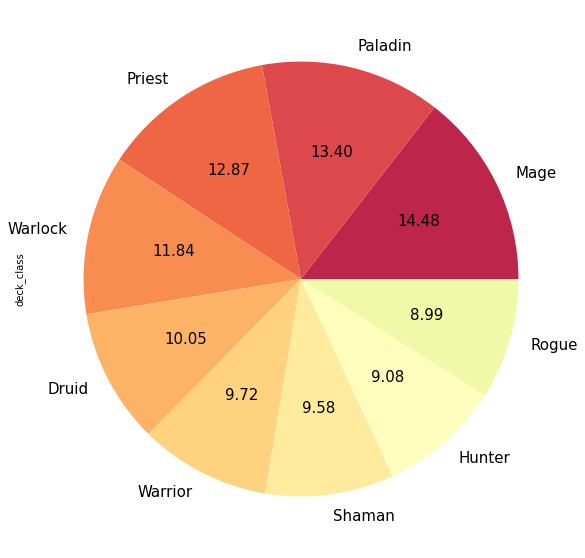

In [16]:
deck_class_w = decks_w['deck_class'].value_counts()
deck_class_graphic = deck_class_w.to_frame().reset_index()
colors = {
    'Druid' : '#fdb365',
    'Hunter' : '#fffebe',
    'Mage' : '#be254a',
    'Paladin' : '#dc484c',
    'Priest' : '#ef6645',
    'Rogue' : '#f0f9a7',
    'Shaman' : '#feeb9d',
    'Warlock' : '#f88c51',
    'Warrior' : '#fed27f',
}

colors = collections.OrderedDict(sorted(colors.items()))

deck_class_graphic['color'] = deck_class_graphic['index'].replace(colors)
deck_class_w.plot.pie(
    y='deck_class', 
    labels=deck_class_graphic['index'], 
    colors=deck_class_graphic['color'],
    autopct='%.2f', 
    fontsize=15,
    figsize=(10, 10),
    legend=False,
)
#Para Wild

Este gráfico corresponde al formato de salvaje el cual nos indica que la clase Mago es la más utilizada.

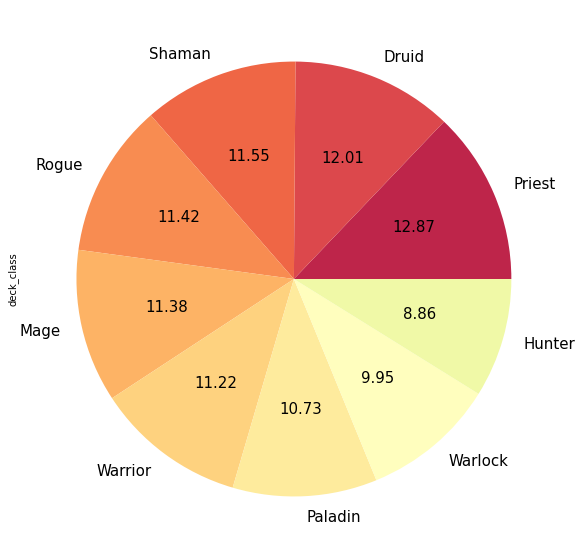

In [17]:
deck_class_s = decks_s['deck_class'].value_counts()
deck_class_graphic = deck_class_s.to_frame().reset_index()
colors = {
    'Druid' : '#dc484c',
    'Hunter' : '#f0f9a7',
    'Mage' : '#fdb365',
    'Paladin' : '#feeb9d',
    'Priest' : '#be254a',
    'Rogue' : '#f88c51',
    'Shaman' : '#ef6645',
    'Warlock' : '#fffebe',
    'Warrior' : '#fed27f',
}
colors = collections.OrderedDict(sorted(colors.items()))

deck_class_graphic['color'] = deck_class_graphic['index'].replace(colors)
deck_class_s.plot.pie(
    y='deck_class', 
    labels=deck_class_graphic['index'], 
    colors=deck_class_graphic['color'],
    autopct='%.2f', 
    fontsize=15,
    figsize=(10, 10),
    legend=False,
)
#Para estandar

Este gráfico corresponde al formato de estándar el cual nos indica que la clase Sacerdote es la más utilizada. Y como podemos ver lo que más se juega en un formato es diferente al otro y esto nos puede indicar que la forma de jugar en cada formato es diferente y se puede evidenciar por las clases que utilizan los jugadores en cada formato la que cambia considerablemente.

Siguiendo con el análisis por formato, ya que sabemos cuáles son las clases más utilizadas vamos a ver los arquetipos de mazos que hacen referencia a las cartas que utilizan para llevar a cabo una estrategia de juego. Antes de empezar se ha verificado que existen muchos mazos sin un arquetipo definido. Estos por lo que se pudo observar eran arquetipos Unknown y Edit los cuales no indican ninguna información, entonces se procede a filtrar los mazos que contengan estos datos.

In [18]:
decks_conocidos_s = decks_s[decks_s['deck_archetype'] != 'Unknown'] #Se filtra y se crea un subconjunto donde no hayan decks con el valor "Unknown"
decks_conocidos_s = decks_conocidos_s[decks_conocidos_s['deck_archetype'] != 'Edit'] #Y luego se filtra nuevamente sacando los arqueotipos de decks que son "Edit"
print('Cantidad de decks presentes luego del filtrado:', len(decks_conocidos_s))

Cantidad de decks presentes luego del filtrado: 92192


In [19]:
decks_conocidos_w = decks_w[decks_w['deck_archetype'] != 'Unknown'] #Se filtra y se crea un subconjunto donde no hayan decks con el valor "Unknown"
decks_conocidos_w = decks_conocidos_w[decks_conocidos_w['deck_archetype'] != 'Edit'] #Y luego se filtra nuevamente sacando los arqueotipos de decks que son "Edit"
print('Cantidad de decks presentes luego del filtrado:', len(decks_conocidos_w))

Cantidad de decks presentes luego del filtrado: 11361


Luego del filtrado se procede a comprobar los arquetipos más jugados de las clases Mago y Sacerdote, ya que estas fueron las que lideraban en los gráficos anteriores. La razón de hacer este análisis es para ver el porqué cambió de clase más utilizada en un formato en comparación a su contraparte, para aquello vamos a comparar cada clase entre los formatos Salvaje y Estándar para ver qué arquetipo se está jugando en cada uno, ya que el arquetipo de juego indica una estrategia con el uso de las cartas.

<Figure size 432x288 with 0 Axes>

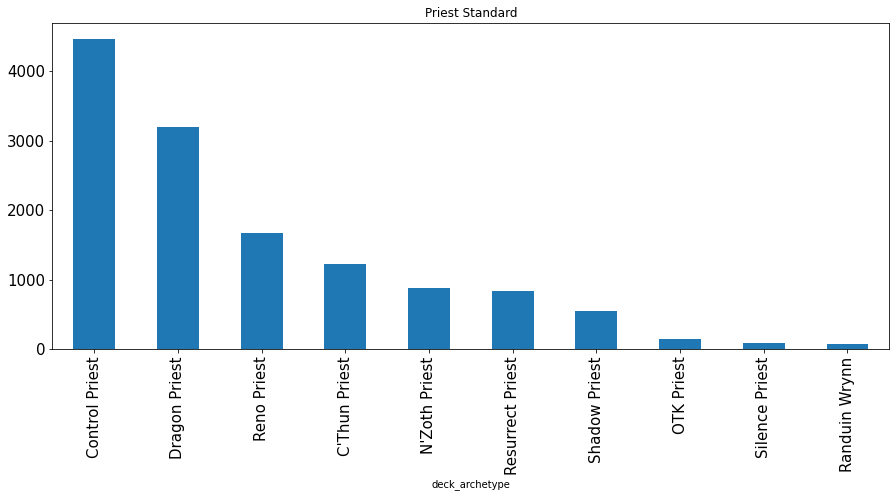

In [20]:
decks_priest_s = decks_conocidos_s[decks_conocidos_s['deck_class'] == 'Priest']
contador = decks_priest_s.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Priest Standard',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

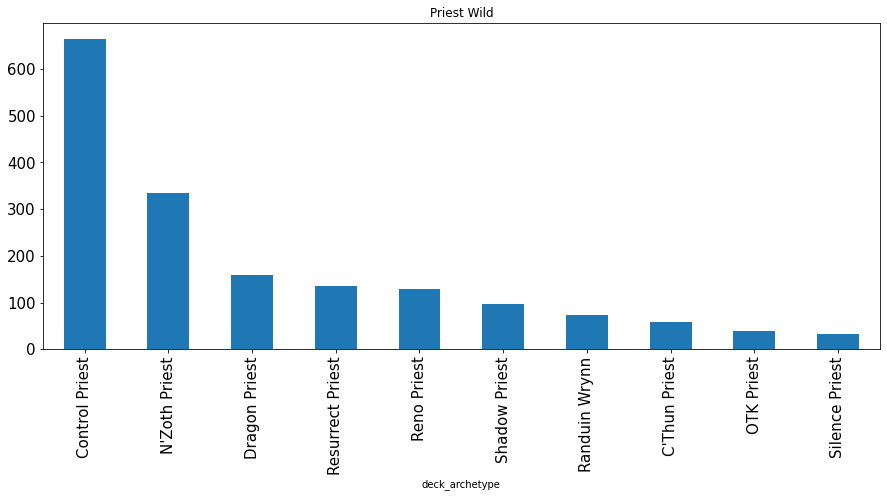

In [21]:
decks_priest_w = decks_conocidos_w[decks_conocidos_w['deck_class'] == 'Priest']
contador = decks_priest_w.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Priest Wild',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

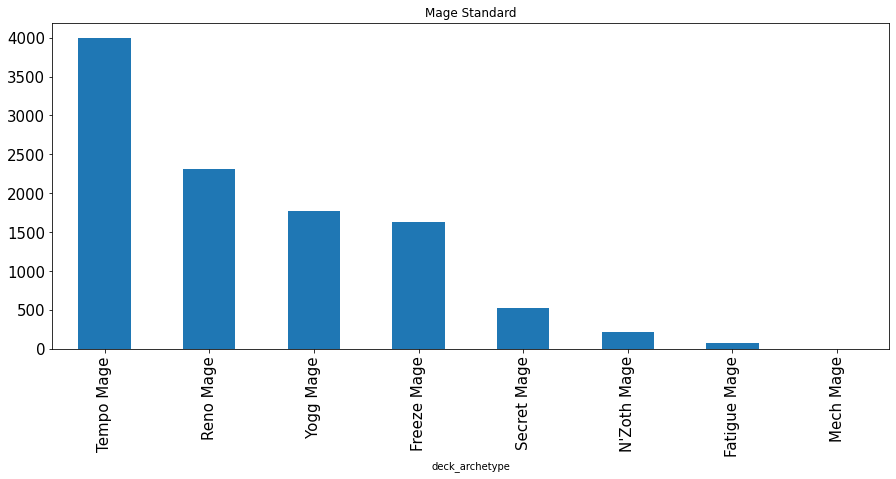

In [22]:
decks_mage = decks_conocidos_s[decks_conocidos_s['deck_class'] == 'Mage']
contador = decks_mage.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Mage Standard',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

<Figure size 432x288 with 0 Axes>

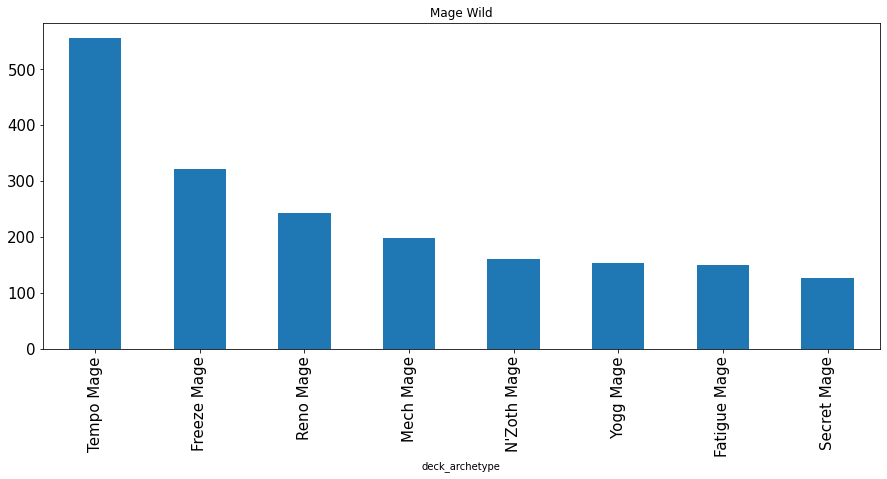

In [23]:
decks_mage = decks_conocidos_w[decks_conocidos_w['deck_class'] == 'Mage']
contador = decks_mage.groupby(['deck_class', 'deck_archetype']).size().reset_index()
for i, group in contador.groupby('deck_class'):
    fig = plt.figure()
    group.sort_values(0, ascending=False).plot(
        kind='bar', 
        x='deck_archetype', 
        title='Mage Wild',
        legend=False,
        figsize=(15, 6),
        fontsize=15,
    )

Como se puede observar en los gráficos anteriores, para el caso de la clase Sacerdote no hubo mucho cambio en los arquetipos jugados entre los formatos. Al igual que en la clase Mago. Por lo tanto se puede concluir que el cambio de la clase que lideraba en los formatos Estándar y Salvaje se debe a que dentro del juego existe la rotación de cartas que significa que las cartas de estándar de la temporada pasan al formato de salvaje y aparecen nuevas cartas para el formato estándar para reemplazar a las que se habían ido a salvaje, por lo tanto se potenciaba a ciertos mazos y ocurre que en el caso de mago que era más utilizado en estándar se fue debilitando en el formato salvaje por la potencia de otras clases. En este caso el análisis no arroja información relevante que se pueda inferir respecto a nuestra propuesta principal, ya que no existen cambios significativos en cada formato.

<a name="item5"></a>
## Preguntas y Problemas


1. Problema de clasificación binaria basado en la variable "deck_format".

2. Encontrar una característica o atributos de un mazo que puedan realizar una mejor clasificación de un formato.

3. ¿Cuáles serían los atributos que puedan permitir hacer una mejor predicción del formato de un mazo?

<a name="item6"></a>
## Propuesta Experimental 



* Como sabemos que un mazo se compone de atributos que hacen referencia a cartas del mazo, vamos a agrupar cartas que se juegan en un formato y en el otro para así lograr hacer una clasificación de un mazo respecto a las cartas que utiliza, para aquello utilizaremos una técnica de clustering.

* Vamos a clasificar con 3 modelos árbol de decisión, regresión logística y naive bayes para identificar y comparar modelos sirve para clasificar el formato de un mazo.

* Analizaremos la correlación de los atributos no relacionados a las cartas de un mazo con el formato de este para así detectar cuáles son los atributos nos permiten hacer una mejor clasificación.


<a name="item7"></a>
## Experimento preliminar

Para realizar el experimento utilizaremos el subconjunto "filter_deck", ya que contiene todos los datos necesarios para trabajar los modelos.

In [24]:
card_columnas = ['card_{}'.format(str(i)) for i in range(30)]

In [25]:
def predecir_formato_arbol(decks_df, card_columnas):

    X = decks_df[card_columnas]
    y = decks_df['deck_format']

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Arbol de decision
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    print(classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    
    return clf

In [26]:
prediccion_arbol = predecir_formato_arbol(filter_deck, card_columnas)

              precision    recall  f1-score   support

           S       0.99      0.99      0.99     37802
           W       0.99      1.00      1.00     43580

    accuracy                           0.99     81382
   macro avg       0.99      0.99      0.99     81382
weighted avg       0.99      0.99      0.99     81382

Matriz de confusión: 
 [[37572   230]
 [  202 43378]]


El modelo muestra un rendimiento anormalmente alto en todas sus métricas, lo cual puede significar Overfitting, pero la matriz de confusión muestra que la distribución de TP y TN refleja propiamente el comportamiento del modelo.

In [27]:
def predecir_formato_bayes(decks_df, card_columnas):

    X = decks_df[card_columnas]
    y = decks_df['deck_format']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    
    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    print(classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    return clf

In [28]:
prediccion_bayes = predecir_formato_bayes(filter_deck, card_columnas)

              precision    recall  f1-score   support

           S       0.47      1.00      0.64     75829
           W       0.65      0.00      0.00     86934

    accuracy                           0.47    162763
   macro avg       0.56      0.50      0.32    162763
weighted avg       0.56      0.47      0.30    162763

Matriz de confusión: 
 [[75804    25]
 [86888    46]]


El rendimiento de este modelo fue mucho más bajo que lo observado en el árbol de decisión, en especial en el formato Salvaje.

In [29]:
from sklearn import metrics
def predecir_formato_reg_logistica(decks_df, card_columnas):

    X = decks_df[card_columnas].values
    y = decks_df['deck_format'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
    
    # Regresion logistica
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    print (classification_report(y_test, pred))
    print('Matriz de confusión: \n', metrics.confusion_matrix(y_test, pred))
    
    return clf

In [30]:
prediccion_reg_logistica = predecir_formato_reg_logistica(filter_deck, card_columnas)

              precision    recall  f1-score   support

           S       0.50      0.90      0.64     75640
           W       0.71      0.20      0.32     87123

    accuracy                           0.53    162763
   macro avg       0.60      0.55      0.48    162763
weighted avg       0.61      0.53      0.47    162763

Matriz de confusión: 
 [[68241  7399]
 [69324 17799]]


En comparación al árbol de decisión el rendimiento es mucho peor, en especial en la categorización de mazos Salvaje, conteniendo un alto número de FN.

De manera preliminar podemos decir que el modelo con mejor rendimiento ha sido el árbol de decisión, aunque queda por ver si el comportamiento que presenta es realmente como se observa.

<a name="item8"></a>
## Trabajo realizado


Armin Rodríguez: Limpieza de datos y apoyo en exploración de datos.

Rodrigo Valenzuela: Redacción introducción y presentación, desarrollo de preguntas, retroalimentación de cambios. 

Nicolás Hidalgo: Redacción y Exploración de datos 

Pablo Nahuelpán: Redacción de preguntas y propuestas, código de modelos.

<a name="item9"></a>
# Referencias:

[1] HeartStone. (2014, 11 marzo). [Software]. En Blizzard Entertainment (24.2). Peter McConnell. https://hearthstone.blizzard.com/es-es

[2] HeathPwn. (2022). HeathPwn. https://www.hearthpwn.com/

# Repositorio almacenado y dataset:

https://raw.githubusercontent.com/ArminRodriguez1/ig_Datos/main/data.csv

[3] History of Hearthstone. (2017, 6 julio). Kaggle. Recuperado 7 de octubre de 2022, de https://www.kaggle.com/datasets/romainvincent/history-of-hearthstone

<a name="item10"></a>
# Anexo:

*   TP: True positive (Positivo verdadero)
*   TN: True negative (Positivo negativo)
*   FN: False negative (Falso negativo)